In [193]:
import numpy as np
import pandas as pd
import nltk
import re
import pickle
import string

%matplotlib inline

In [4]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Text Normalization

In [5]:

from html import unescape
from nltk.corpus import wordnet as wn

CONTRACTION_MAP = pickle.load(open('contraction_map.pkl', 'rb'))

wnl = nltk.wordnet.WordNetLemmatizer()

stop_words = set(nltk.corpus.stopwords.words('english'))


def parse_document(doc):
    doc = re.sub('\n', ' ', doc).strip()    
    return [sent.strip() for sent in nltk.sent_tokenize(doc)]

def unescape_html(text):
    return unescape(text)

def expand_contractions(text, contraction_map):
    
    pat = re.compile("({})".format("|".join(contraction_map.keys())), 
                     flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(match_object):
        text = match_object.group(0)
        new_text = contraction_map.get(text, contraction_map.get(text.lower()))
        return text[0] + new_text[1:]
        
    return pat.sub(expand_match, text)


def remove_special_characters(text):
    pat = re.compile("[{}]".format(re.escape(string.punctuation)))
    return pat.sub("", text)


def remove_stopwords(text):
    return " ".join(w for w in nltk.word_tokenize(text) if w not in stop_words)


def tokenize_text(text):
    return [w.strip() for w in nltk.word_tokenize(text)]


def lemmatize_text(text):
    
    def penn_to_wn(tag):
        if tag.startswith('JJ'):
            return wn.ADJ
        elif tag.startswith('NN'):
            return wn.NOUN
        elif tag.startswith('RB'):
            return wn.ADV
        elif tag.startswith('VB'):
            return wn.VERB
        return None

    text_tagged = ((word.lower(), penn_to_wn(tag)) for word, tag in nltk.pos_tag(tokenize_text(text)))
    return " ".join(wnl.lemmatize(word, pos=tag) if tag else word for word, tag in text_tagged)


def normalize_corpus(corpus, lemmatize=True, tokenize=False):
    
    normalized_corpus = []
    for text in corpus:
        
        text = unescape_html(text)
        text = expand_contractions(text, CONTRACTION_MAP)
        
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        
        if tokenize:
            normalized_corpus.append(tokenize_text(text))
        else:
            normalized_corpus.append(text)
        
    return normalized_corpus

### Feature Extraction

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def build_feature_matrix(corpus, feature_type='freq'):
    
    if feature_type == 'freq':
        vectorizer = CountVectorizer(binary=False, min_df=1, ngram_range=(1, 1))
    
    elif feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1, ngram_range=(1, 1))
    
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
    
    else:
        raise Exception('Invalid feature type:\n\
                        Possible values: {}, {}, {}'.format("`freq`", "`binary`", "`tfidf`"))
    
    features = vectorizer.fit_transform(corpus).astype(float)
    
    return vectorizer, features


### Collocations

In [7]:
from nltk.corpus import gutenberg
from operator import itemgetter

In [8]:
def flatten_corpus(corpus):
    return " ".join(text.strip() for text in corpus)

def compute_ngrams(sequence, n_gram):
    return list(zip(*(sequence[i:] for i in range(n_gram))))


def get_top_ngrams(corpus, ngram_val=1, limit=5):
    
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    
    ngrams = compute_ngrams(tokens, n_gram=ngram_val)
    ngrams_freq = nltk.FreqDist(samples=ngrams)
    sorted_ngrams = sorted(ngrams_freq.items(), 
                           key=lambda x: x[1], 
                           reverse=True)
    return [(" ".join(ngram), freq) for ngram, freq in  sorted_ngrams[:limit]]

In [9]:
alice = gutenberg.sents(fileids='carroll-alice.txt')

In [10]:
alice = [" ".join(s) for s in alice]

In [11]:
norm_alice = list(filter(None, normalize_corpus(alice, lemmatize=False)))

In [12]:
alice[0]

"[ Alice ' s Adventures in Wonderland by Lewis Carroll 1865 ]"

In [13]:
norm_alice[0]

'alice adventures wonderland lewis carroll 1865'

In [14]:
compute_ngrams([1,2,3,4], 3)

[(1, 2, 3), (2, 3, 4)]

In [15]:
get_top_ngrams(norm_alice, ngram_val=2, limit=10)

[('said alice', 123),
 ('mock turtle', 56),
 ('march hare', 31),
 ('said king', 29),
 ('thought alice', 26),
 ('said hatter', 22),
 ('white rabbit', 22),
 ('said mock', 20),
 ('said gryphon', 18),
 ('said caterpillar', 18)]

In [16]:
get_top_ngrams(norm_alice, ngram_val=3, limit=10)

[('said mock turtle', 20),
 ('said march hare', 10),
 ('poor little thing', 6),
 ('certainly said alice', 5),
 ('little golden key', 5),
 ('march hare said', 5),
 ('white kid gloves', 5),
 ('mock turtle said', 5),
 ('mouse mouse mouse', 4),
 ('ootiful soo oop', 4)]

### nltk - collocation finders

In [17]:
# bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

In [18]:
bi_finder = BigramCollocationFinder.from_documents(list(map(nltk.word_tokenize, norm_alice)))

In [19]:
bigram_measures = BigramAssocMeasures()

In [20]:
bi_finder.nbest(bigram_measures.raw_freq, 10)

[('said', 'alice'),
 ('mock', 'turtle'),
 ('march', 'hare'),
 ('said', 'king'),
 ('thought', 'alice'),
 ('said', 'hatter'),
 ('white', 'rabbit'),
 ('said', 'mock'),
 ('said', 'caterpillar'),
 ('said', 'gryphon')]

In [21]:
bi_finder.nbest(bigram_measures.pmi, 10)

[('abide', 'figures'),
 ('acceptance', 'elegant'),
 ('accounting', 'tastes'),
 ('accustomed', 'usurpation'),
 ('act', 'crawling'),
 ('adjourn', 'immediate'),
 ('adoption', 'energetic'),
 ('affair', 'trusts'),
 ('agony', 'terror'),
 ('alarmed', 'proposal')]

In [22]:
# trigrams
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

In [23]:
tri_finder = TrigramCollocationFinder.from_documents(list(map(nltk.word_tokenize, norm_alice)))

In [24]:
trigram_measures = TrigramAssocMeasures()

In [25]:
tri_finder.nbest(trigram_measures.raw_freq, 10)

[('said', 'mock', 'turtle'),
 ('said', 'march', 'hare'),
 ('poor', 'little', 'thing'),
 ('little', 'golden', 'key'),
 ('march', 'hare', 'said'),
 ('mock', 'turtle', 'said'),
 ('white', 'kid', 'gloves'),
 ('beau', 'ootiful', 'soo'),
 ('certainly', 'said', 'alice'),
 ('might', 'well', 'say')]

In [26]:
tri_finder.nbest(trigram_measures.pmi, 10)

[('accustomed', 'usurpation', 'conquest'),
 ('adjourn', 'immediate', 'adoption'),
 ('adoption', 'energetic', 'remedies'),
 ('ancient', 'modern', 'seaography'),
 ('apple', 'roast', 'turkey'),
 ('arithmetic', 'ambition', 'distraction'),
 ('brother', 'latin', 'grammar'),
 ('canvas', 'bag', 'tied'),
 ('cherry', 'tart', 'custard'),
 ('circle', 'exact', 'shape')]

### Weighted Tag-Based Phrase Extraction

In [27]:
import itertools
import nltk
from gensim import corpora, models

In [28]:
toy_text = """
Elephants are large mammals of the family Elephantidae 
and the order Proboscidea. Two species are traditionally recognised, 
the African elephant and the Asian elephant. Elephants are scattered 
throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male 
African elephants are the largest extant terrestrial animals. All 
elephants have a long trunk used for many purposes, 
particularly breathing, lifting water and grasping objects. Their 
incisors grow into tusks, which can serve as weapons and as tools 
for moving objects and digging. Elephants' large ear flaps help 
to control their body temperature. Their pillar-like legs can 
carry their great weight. African elephants have larger ears 
and concave backs while Asian elephants have smaller ears 
and convex or level backs.  
"""

In [29]:
noun_grammar = r'NP: {<DT>? <JJ>* <NN.*>+}'
sentences = parse_document(toy_text)

def get_chunks(sentences, grammar=noun_grammar):

    # build chunker based on grammar pattern
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)

    for sentence in sentences:
        # POS tag sentences
        tagged_sents = nltk.pos_tag_sents([nltk.word_tokenize(sentence)])

        # extract chunks: tree
        chunks = [chunker.parse(tagged_sent) for tagged_sent in tagged_sents]

        # get word, pos_tag, chunk_tag triples
        wtc_sents = [nltk.chunk.tree2conlltags(chunk) for chunk in chunks]

        flattened_chunks = list(itertools.chain.from_iterable(wtc for wtc in wtc_sents))

        # get valid chunks based on tags
        valid_chunks_tagged = [(status, list(chunk)) 
                               for status, chunk in itertools.groupby(flattened_chunks, lambda x: x[-1]!='O') if status]

        # append words in each chunk to make phrases
        valid_chunks = [" ".join(w.lower() for w,_,_ in chunks if w.lower() not in stop_words) 
                        for _, chunks in valid_chunks_tagged]

        all_chunks.append(valid_chunks)
    
    return all_chunks


def get_tfidf_weighted_keyphrases(sentences, grammar=r"NP: <DT>? <JJ>* <NN.*>+", top_n=10):
    
    valid_chunks = get_chunks(sentences, grammar)
    
    # build tf-idf based model
    chunk_dict = corpora.Dictionary(valid_chunks)
    corpus = [chunk_dict.doc2bow(chunk) for chunk in valid_chunks]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    # get phrases and their tf-idf weights
    weighted_phrases = {chunk_dict.get(idx): round(val, 3) 
                            for doc in corpus_tfidf 
                            for (idx, val) in doc}
    weighted_phrases = sorted(weighted_phrases.items(), key=lambda x: x[1], reverse=True)
    return weighted_phrases[:top_n]

In [30]:
get_chunks(parse_document(toy_text), noun_grammar)

[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'],
 ['species', 'african elephant', 'asian elephant'],
 ['elephants', 'sub-saharan africa', 'south asia', 'southeast asia'],
 ['male african elephants', 'extant terrestrial animals'],
 ['elephants',
  'long trunk',
  'many purposes',
  'breathing',
  'water',
  'grasping objects'],
 ['incisors', 'tusks', 'weapons', 'tools', 'objects', 'digging'],
 ['elephants', 'large ear flaps', 'body temperature'],
 ['pillar-like legs', 'great weight'],
 ['african elephants',
  'ears',
  'backs',
  'asian elephants',
  'ears',
  'convex',
  'level backs']]

In [31]:
get_tfidf_weighted_keyphrases(sentences, noun_grammar, 10)

[('male african elephants', 0.707),
 ('great weight', 0.707),
 ('pillar-like legs', 0.707),
 ('extant terrestrial animals', 0.707),
 ('body temperature', 0.684),
 ('large ear flaps', 0.684),
 ('ears', 0.667),
 ('species', 0.577),
 ('african elephant', 0.577),
 ('asian elephant', 0.577)]

In [32]:
get_tfidf_weighted_keyphrases(norm_alice, noun_grammar, 20)

[('particular bill', 1.0),
 ('prisoner', 1.0),
 ('manage twelfth', 1.0),
 ('blacking believe', 1.0),
 ('chapter ii', 1.0),
 ('end bill french music', 1.0),
 ('tails mouths crumbs', 1.0),
 ('continued way', 1.0),
 ('mock turtle sing song', 1.0),
 ('experiment', 1.0),
 ('play croquet queen day', 1.0),
 ('thump', 1.0),
 ('book', 1.0),
 ('deny', 1.0),
 ('next question world', 1.0),
 ('inquired alice', 1.0),
 ('oh poor hands', 1.0),
 ('stay', 1.0),
 ('right think', 1.0),
 ('melancholy tone', 1.0)]

### Topic Modeling

In [33]:
# 2 distinct topics corpus: [animal, programming language]

toy_corpus = ["The fox jumps over the dog",
"The fox is very clever and quick",
"The dog is slow and lazy",
"The cat is smarter than the fox and the dog",
"Python is an excellent programming language",
"Java and Ruby are other programming languages",
"Python and Java are very popular programming languages",
"Python programs are smaller than Java programs"]


#### 1) Latent Semantic Indexing (LSI)

In [34]:
from gensim import corpora, models
import numpy as np

In [35]:
norm_tokenized_corpus = normalize_corpus(toy_corpus, tokenize=True)
norm_tokenized_corpus

[['fox', 'jump', 'dog'],
 ['fox', 'clever', 'quick'],
 ['dog', 'slow', 'lazy'],
 ['cat', 'smarter', 'fox', 'dog'],
 ['python', 'excellent', 'programming', 'language'],
 ['java', 'ruby', 'programming', 'language'],
 ['python', 'java', 'popular', 'programming', 'language'],
 ['python', 'program', 'small', 'java', 'program']]

In [36]:
# build Bag-of-word model
bow = corpora.Dictionary(norm_tokenized_corpus)

bow_corpus = [bow.doc2bow(doc) for doc in norm_tokenized_corpus]

In [37]:
bow_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(1, 1), (3, 1), (4, 1)],
 [(0, 1), (5, 1), (6, 1)],
 [(0, 1), (1, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)],
 [(9, 1), (11, 1), (13, 1), (14, 1)],
 [(9, 1), (10, 1), (11, 1), (14, 1), (15, 1)],
 [(10, 1), (14, 1), (16, 2), (17, 1)]]

In [38]:
# tfidf model
tfidf = models.TfidfModel(bow_corpus)

tfidf_corpus = tfidf[bow_corpus]

In [39]:
# fix the number of topic
n_topic = 2

lsi = models.LsiModel(corpus=tfidf_corpus, num_topics=n_topic, id2word=bow)

In [40]:
for idx, topic in lsi.print_topics(n_topic):
    print("Topic {}:\n{}\n".format(idx, topic))

Topic 0:
0.459*"language" + 0.459*"programming" + 0.344*"python" + 0.344*"java" + 0.336*"popular" + 0.318*"excellent" + 0.318*"ruby" + 0.148*"program" + 0.074*"small" + 0.000*"dog"

Topic 1:
-0.459*"dog" + -0.459*"fox" + -0.444*"jump" + -0.322*"cat" + -0.322*"smarter" + -0.208*"lazy" + -0.208*"slow" + -0.208*"clever" + -0.208*"quick" + 0.000*"language"



In [72]:
def print_topic_gensim(topic_model, total_topic=1, weight_threshold=0.0001, 
                       display_weights=False, num_terms=None):
    for i in range(total_topic):
        topic = topic_model.show_topic(i)
        
        topic = [(word, round(val, 2)) for  word, val in topic 
                                         if abs(val) > weight_threshold]
        
        print("Topic {}:".format(i))
        if not display_weights:
            print([w for w,_ in topic][:num_terms])
        else:
            print(topic[:num_terms])
        print()

In [42]:
print_topic_gensim(lsi, total_topic=2, num_terms=5)

Topic 0:
[('language', 0.46000000000000002), ('programming', 0.46000000000000002), ('python', 0.34000000000000002), ('java', 0.34000000000000002), ('popular', 0.34000000000000002)]

Topic 1:
[('dog', -0.46000000000000002), ('fox', -0.46000000000000002), ('jump', -0.44), ('cat', -0.32000000000000001), ('smarter', -0.32000000000000001)]



### LSI using SVD

In [43]:
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

def build_tfidf_matrix(corpus):
    tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
    features = tfidf.fit_transform(corpus)
    return tfidf, features

def get_topics_with_terms_and_weights(weights, feature_names):
    topics = []
    for weight in weights:
        a = pd.Series(weight, index=feature_names)
        idx = a.abs().argsort().values[::-1]
        topics.append(a.iloc[idx].round(3))
    return topics


def train_lsi_model_gensim(corpus, n_topics=2):
    
    corpus = normalize_corpus(corpus, tokenize=True)
    bow = corpora.Dictionary(corpus)
    bow_corpus = [bow.doc2bow(doc) for doc in corpus]
    tfidf = models.TfidfModel(bow_corpus)
    tfidf_corpus = tfidf[bow_corpus]
    
    lsi = models.LsiModel(corpus=tfidf_corpus, 
                          num_topics=n_topics, 
                          id2word=bow)
    return lsi

def print_topics(weights, feature_names, weight_threshold=0.0001, num_terms=None):
    
    topics = get_topics_with_terms_and_weights(weights, feature_names)
    for i, topic in enumerate(topics, 1):
        topic = topic.loc[topic.abs() >= weight_threshold]
        print("Topic {}:\n{}".format(i, topic[:num_terms]))
        print()

In [45]:
norm_corpus = normalize_corpus(toy_corpus)

# tfidf_matrix -> [n_docs, n_words]
vectorizer, tfidf_matrix = build_tfidf_matrix(norm_corpus)
tfidf_matrix.shape

(8, 18)

In [46]:
# td_matrix -> [n_words, n_docs]
td_matrix = tfidf_matrix.T
td_matrix = td_matrix.multiply(td_matrix > 0)

In [47]:
n_topic = 2
feature_names = vectorizer.get_feature_names()

In [48]:
u, s, vt = low_rank_svd(td_matrix, singular_count=n_topic)

In [49]:
weights = (u * s).T    # shape -> [n_topic, n_words]

In [50]:
topics = get_topics_with_terms_and_weights(weights, feature_names)

In [51]:
print(topics[0])

dog            0.724
fox            0.724
jump           0.430
smarter        0.336
cat            0.336
slow           0.234
lazy           0.234
quick          0.234
clever         0.234
programming    0.000
language       0.000
java           0.000
python         0.000
popular        0.000
program        0.000
ruby           0.000
excellent      0.000
small          0.000
dtype: float64


In [52]:
print(topics[1])

programming   -0.729
language      -0.729
python        -0.565
java          -0.565
popular       -0.341
ruby          -0.333
excellent     -0.333
program       -0.213
small         -0.106
dog            0.000
fox            0.000
lazy           0.000
slow           0.000
jump           0.000
smarter        0.000
cat            0.000
quick          0.000
clever         0.000
dtype: float64


In [53]:
topics[0][(topics[0].abs() > .15).values]

dog        0.724
fox        0.724
jump       0.430
smarter    0.336
cat        0.336
slow       0.234
lazy       0.234
quick      0.234
clever     0.234
dtype: float64

### Latent Dirichlet Allocation

In [68]:
def train_lda_model_gensim(corpus, total_topics=2):
    
    norm_tokenized_corpus = normalize_corpus(corpus, tokenize=True)
    id2word = corpora.Dictionary(norm_tokenized_corpus)
    mapped_corpus = [id2word.doc2bow(doc) for doc in norm_tokenized_corpus]
    tfidf = models.TfidfModel(mapped_corpus)
    tfidf_corpus = tfidf[mapped_corpus]
    lda = models.LdaModel(tfidf_corpus, 
                          num_topics=total_topics, 
                          id2word=id2word, 
                          iterations=1000)
    return lda

In [69]:
lda_gensim = train_lda_model_gensim(toy_corpus, total_topics=2)

In [74]:
print_topic_gensim(lda_gensim, total_topic=2, display_weights=True, num_terms=10)

Topic 0:
[('language', 0.070000000000000007), ('jump', 0.070000000000000007), ('fox', 0.070000000000000007), ('dog', 0.059999999999999998), ('programming', 0.059999999999999998), ('excellent', 0.059999999999999998), ('quick', 0.059999999999999998), ('clever', 0.059999999999999998), ('lazy', 0.059999999999999998), ('python', 0.059999999999999998)]

Topic 1:
[('java', 0.070000000000000007), ('popular', 0.070000000000000007), ('programming', 0.059999999999999998), ('program', 0.059999999999999998), ('ruby', 0.059999999999999998), ('language', 0.059999999999999998), ('python', 0.059999999999999998), ('smarter', 0.059999999999999998), ('dog', 0.059999999999999998), ('fox', 0.059999999999999998)]



In [75]:
from sklearn.decomposition import LatentDirichletAllocation

In [76]:
norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_tfidf_matrix(norm_corpus)

In [77]:
total_topics = 2
lda = LatentDirichletAllocation(n_components=total_topics, 
                                max_iter=100, 
                                learning_method='online', 
                                learning_offset=50, 
                                random_state=42)

lda.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=2, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [79]:
feature_names = vectorizer.get_feature_names()
weights = lda.components_

weights.shape, len(feature_names)

((2, 18), 18)

In [85]:
print_topics(weights, feature_names, num_terms=7)

Topic 1:
fox        1.846
dog        1.538
jump       1.173
clever     1.113
quick      1.113
cat        1.057
smarter    1.055
dtype: float64

Topic 2:
programming    1.732
language       1.727
java           1.615
python         1.583
program        1.286
ruby           1.090
slow           1.078
dtype: float64



### Non-negative Matrix Factorization

In [86]:
from sklearn.decomposition import NMF

In [89]:
norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_tfidf_matrix(norm_corpus)

In [90]:
n_topic = 2
nmf = NMF(n_components=n_topic, init='random', random_state=42, alpha=.1, l1_ratio=.5)

In [91]:
nmf.fit(tfidf_matrix)

NMF(alpha=0.1, beta_loss='frobenius', init='random', l1_ratio=0.5,
  max_iter=200, n_components=2, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [92]:
feature_names = vectorizer.get_feature_names()
weights = nmf.components_

In [95]:
print_topics(weights, feature_names, num_terms=10)

Topic 1:
programming    0.551
language       0.551
python         0.402
java           0.402
popular        0.241
excellent      0.235
ruby           0.235
program        0.090
small          0.029
dtype: float64

Topic 2:
dog        0.573
fox        0.573
jump       0.346
smarter    0.255
cat        0.255
slow       0.132
lazy       0.132
quick      0.132
clever     0.132
dtype: float64



### Extracting Topics from Product Reviews

In [100]:
data = pd.read_csv('amazon_skyrim_reviews.csv')

In [101]:
data.head()

,Reviews
0,After playing this game over 100 hours in less...
1,"a great ARPG, the improvements on the mechanic..."
2,A little buggy but such an amazing game it doe...
3,"Amazing game, cool graphics, cool gameplay, co..."
4,"Bethesda adds here what it left out, or what w..."


In [102]:
data.shape

(312, 1)

In [105]:
corpus = data['Reviews'].values

total_topics = 5

In [104]:
print(corpus[12])

I base the value of a game on the amount of enjoyable gameplay I can get out of it and this one was definitely worth the price!


In [106]:
# Latent Semantic Indexing
lsi_gensim = train_lsi_model_gensim(corpus, n_topics=total_topics)

In [107]:
print_topic_gensim(lsi_gensim, total_topic=total_topics, num_terms=10)

Topic 0:
['skyrim', 'like', 'one', 'play', 'quest', 'go', 'get', 'time', 'oblivion', 'good']

Topic 1:
['recommend', 'love', 'great', 'ever', 'best', 'buy', 'highly', 'elder', 'scroll', 'level']

Topic 2:
['recommend', 'fun', 'highly', 'love', 'ever', 'wonderful', 'best', 'series', 'definitely', 'scroll']

Topic 3:
['fun', 'recommend', 'scroll', 'elder', 'highly', 'ever', 'wonderful', 'graphic', 'best', 'cool']

Topic 4:
['fun', 'love', 'scroll', 'elder', 'highly', 'series', 'hour', 'recommend', 'always', 'ive']



In [108]:
# LDA gensim
lda_gensim = train_lda_model_gensim(corpus, total_topics=total_topics)

In [109]:
print_topic_gensim(lda_gensim, total_topic=total_topics, num_terms=10)

Topic 0:
['skyrim', 'fun', 'one', 'great', 'like', 'play', 'go', 'buy', 'ever', 'glitch']

Topic 1:
['skyrim', 'quest', 'get', 'never', 'think', 'big', 'character', 'play', 'make', 'world']

Topic 2:
['play', 'love', 'get', 'quest', 'hour', 'oblivion', 'graphic', 'one', 'time', 'system']

Topic 3:
['recommend', 'love', 'like', 'fun', 'good', 'even', 'really', 'great', 'scroll', 'elder']

Topic 4:
['scroll', 'elder', 'oblivion', 'one', 'play', 'best', 'much', 'ever', 'love', 'go']



In [110]:
# LDA sklearn
norm_corpus = normalize_corpus(corpus)
vectorizer, tfidf_matrix = build_tfidf_matrix(norm_corpus)

lda_sk = LatentDirichletAllocation(n_components=total_topics, 
                                   learning_method='online', learning_offset=50, max_iter=100)

lda_sk.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [112]:
feature_names = vectorizer.get_feature_names()
weights = lda_sk.components_

print_topics(weights, feature_names, num_terms=10)

Topic 1:
de                 0.571
crédito            0.398
skyrimseguridad    0.398
tarjeta            0.398
compras            0.398
recomiendo         0.398
momento            0.398
responsabilidad    0.398
futuras            0.398
para               0.398
dtype: float64

Topic 2:
love          0.2
fun           0.2
booklet       0.2
unrivaled     0.2
definetley    0.2
factory       0.2
get           0.2
staple        0.2
whereas       0.2
romp          0.2
dtype: float64

Topic 3:
game       0.2
play       0.2
make       0.2
skyrim     0.2
great      0.2
like       0.2
hour       0.2
one        0.2
ever       0.2
graphic    0.2
dtype: float64

Topic 4:
game      38.348
play      17.936
get       13.440
one       12.051
skyrim    11.828
great     11.377
like      11.373
time      11.040
much      10.121
go        10.116
dtype: float64

Topic 5:
meadwaistlength            0.453
peoplemudcrabsgreat        0.453
musicdrinking              0.453
nuff                       0.453
wolfhound

In [113]:
# NNF
nmf = NMF(n_components=total_topics, init='random', 
          random_state=42, alpha=.1, l1_ratio=.5)

nmf.fit(tfidf_matrix)

NMF(alpha=0.1, beta_loss='frobenius', init='random', l1_ratio=0.5,
  max_iter=200, n_components=5, random_state=42, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [114]:
print_topics(nmf.components_, feature_names, num_terms=10)

Topic 1:
game      0.756
get       0.365
skyrim    0.348
play      0.326
time      0.323
like      0.318
quest     0.303
one       0.271
go        0.267
much      0.250
dtype: float64

Topic 2:
game         0.685
recommend    0.672
love         0.653
great        0.456
highly       0.417
play         0.276
wonderful    0.265
like         0.220
would        0.153
graphic      0.148
dtype: float64

Topic 3:
scroll       0.731
elder        0.721
series       0.286
always       0.280
love         0.234
pass         0.227
buy          0.141
far          0.140
franchise    0.122
every        0.121
dtype: float64

Topic 4:
fun            1.335
game           0.488
much           0.194
graphic        0.110
improvement    0.094
mission        0.079
expect         0.069
couple         0.063
though         0.062
favorite       0.058
dtype: float64

Topic 5:
ever          0.759
best          0.693
game          0.605
play          0.555
one           0.240
rpg           0.231
great         0.222
d

### Automated Document Summarization

In [115]:
toy_text

"\nElephants are large mammals of the family Elephantidae \nand the order Proboscidea. Two species are traditionally recognised, \nthe African elephant and the Asian elephant. Elephants are scattered \nthroughout sub-Saharan Africa, South Asia, and Southeast Asia. Male \nAfrican elephants are the largest extant terrestrial animals. All \nelephants have a long trunk used for many purposes, \nparticularly breathing, lifting water and grasping objects. Their \nincisors grow into tusks, which can serve as weapons and as tools \nfor moving objects and digging. Elephants' large ear flaps help \nto control their body temperature. Their pillar-like legs can \ncarry their great weight. African elephants have larger ears \nand concave backs while Asian elephants have smaller ears \nand convex or level backs.  \n"

In [117]:
from gensim.summarization import summarize, keywords


def text_summarization_gensim(text, summary_ratio=0.5):
    '''summarize the given text to a fraction of its original size'''
    summary = summarize(text, ratio=summary_ratio, split=True)
    for sentence in summary:
        print(sentence)

In [120]:
text = " ".join(parse_document(toy_text))

In [122]:
text_summarization_gensim(text, summary_ratio=.4)

Two species are traditionally recognised,  the African elephant and the Asian elephant.
All  elephants have a long trunk used for many purposes,  particularly breathing, lifting water and grasping objects.
African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.


In [123]:
sentences = parse_document(toy_text)
norm_sentences = normalize_corpus(sentences, lemmatize=True, tokenize=False)

In [125]:
print(len(norm_sentences))

9


### Latent Semantic Analysis

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
n_topic, n_sentence = 3, 3

In [127]:
bow = CountVectorizer(min_df=1, ngram_range=(1, 1))

In [173]:
sentences = np.array(parse_document(toy_text))

In [174]:
# term-sentence matrix
bow_matrix = bow.fit_transform(sentences).transpose()

In [175]:
bow_matrix = bow_matrix.multiply(bow_matrix > 0).asfptype()

In [176]:
u, s, vt = low_rank_svd(bow_matrix, singular_count=n_topic)

In [177]:
s[s < 0.5] = 0

In [178]:
salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))

In [179]:
idx = np.argsort(salience_scores)[::-1][:n_sentence]

In [180]:
sentences[idx]

array([ 'African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.',
       'Their  incisors grow into tusks, which can serve as weapons and as tools  for moving objects and digging.',
       'Two species are traditionally recognised,  the African elephant and the Asian elephant.'],
      dtype='<U121')

In [226]:
def lsa_text_summarizer(norm_sentences, num_sentences=3, 
                        num_topic=5, sv_threshold=0.5):
    vec, dt_matrix = build_feature_matrix(norm_sentences)
    td_matrix = dt_matrix.transpose()
    td_matrix = td_matrix.multiply(td_matrix > 0)
    
    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topic)
    s[s < sv_threshold*max(s)] = 0
    
    ss = np.sqrt(np.dot(np.square(s), np.square(vt)))
    idx = np.argsort(ss)[::-1][:num_sentences]
    
    for i in idx:
        print(norm_sentences[i])
        print()

### TextRank

In [181]:
import networkx

In [183]:
n_sentences = 3

vec, dt_matrix = build_tfidf_matrix(norm_sentences)

In [185]:
dt_matrix.shape

(9, 59)

In [186]:
similarity_matrix = dt_matrix * dt_matrix.T
similarity_matrix.shape

(9, 9)

In [189]:
np.round(similarity_matrix.todense(), 2)

array([[ 1.  ,  0.07,  0.03,  0.12,  0.03,  0.  ,  0.11,  0.  ,  0.1 ],
       [ 0.07,  1.  ,  0.06,  0.17,  0.05,  0.  ,  0.07,  0.  ,  0.24],
       [ 0.03,  0.06,  1.  ,  0.03,  0.02,  0.  ,  0.03,  0.  ,  0.04],
       [ 0.12,  0.17,  0.03,  1.  ,  0.03,  0.  ,  0.11,  0.  ,  0.17],
       [ 0.03,  0.05,  0.02,  0.03,  1.  ,  0.07,  0.03,  0.  ,  0.04],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.07,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.11,  0.07,  0.03,  0.11,  0.03,  0.  ,  1.  ,  0.  ,  0.25],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.1 ,  0.24,  0.04,  0.17,  0.04,  0.  ,  0.25,  0.  ,  1.  ]])

In [191]:
similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix)

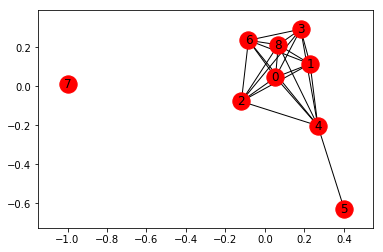

In [196]:
networkx.draw_networkx(similarity_graph)

In [197]:
scores = networkx.pagerank(similarity_graph)

In [199]:
sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]

[(8, 0.12601516066915536), (1, 0.1176994845473083), (3, 0.11551107983088753)]

In [201]:
np.array(norm_sentences)[[8, 1, 3]]

array([ 'african elephant large ear concave back asian elephant small ear convex level back',
       'two specie traditionally recognise african elephant asian elephant',
       'male african elephant large extant terrestrial animal'],
      dtype='<U86')

In [211]:
def textrank_text_summarizer(documents, num_sentences=2):
    
    documents = parse_document(documents)
    norm_doc = normalize_corpus(documents, lemmatize=True)
    vec, tfidf_matrix = build_tfidf_matrix(norm_doc)
    sim_matrix = tfidf_matrix * tfidf_matrix.T
    
    sim_graph = networkx.from_scipy_sparse_matrix(sim_matrix)
    scores = networkx.pagerank(sim_graph)
    
    ranked_scores = sorted(scores.items(), key=lambda x:x[1], reverse=True)
    
    for i in range(num_sentences):
        print(i, ':', documents[ranked_scores[i][0]])
        print()

In [212]:
textrank_text_summarizer(toy_text, num_sentences=3)

0 : African elephants have larger ears  and concave backs while Asian elephants have smaller ears  and convex or level backs.

1 : Two species are traditionally recognised,  the African elephant and the Asian elephant.

2 : Male  African elephants are the largest extant terrestrial animals.



### Summarizing a Product Description

In [213]:
DOCUMENT = """
The Elder Scrolls V: Skyrim is an open world action role-playing video game 
developed by Bethesda Game Studios and published by Bethesda Softworks. 
It is the fifth installment in The Elder Scrolls series, following 
The Elder Scrolls IV: Oblivion. Skyrim's main story revolves around 
the player character and their effort to defeat Alduin the World-Eater, 
a dragon who is prophesied to destroy the world. 
The game is set two hundred years after the events of Oblivion 
and takes place in the fictional province of Skyrim. The player completes quests 
and develops the character by improving skills. 
Skyrim continues the open world tradition of its predecessors by allowing the 
player to travel anywhere in the game world at any time, and to 
ignore or postpone the main storyline indefinitely. The player may freely roam 
over the land of Skyrim, which is an open world environment consisting 
of wilderness expanses, dungeons, cities, towns, fortresses and villages. 
Players may navigate the game world more quickly by riding horses, 
or by utilizing a fast-travel system which allows them to warp to previously 
Players have the option to develop their character. At the beginning of the game, 
players create their character by selecting one of several races, 
including humans, orcs, elves and anthropomorphic cat or lizard-like creatures, 
and then customizing their character's appearance.discovered locations. Over the 
course of the game, players improve their character's skills, which are numerical 
representations of their ability in certain areas. There are eighteen skills 
divided evenly among the three schools of combat, magic, and stealth. 
Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's 
wilderness. Like other creatures, Dragons are generated randomly in the world 
and will engage in combat. 
"""


In [214]:
sentences = parse_document(DOCUMENT)
norm_sentences = normalize_corpus(sentences, lemmatize=True)

In [215]:
# LSA document summarization


['The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.',
 'It is the fifth installment in The Elder Scrolls series, following  The Elder Scrolls IV: Oblivion.',
 "Skyrim's main story revolves around  the player character and their effort to defeat Alduin the World-Eater,  a dragon who is prophesied to destroy the world.",
 'The game is set two hundred years after the events of Oblivion  and takes place in the fictional province of Skyrim.',
 'The player completes quests  and develops the character by improving skills.',
 'Skyrim continues the open world tradition of its predecessors by allowing the  player to travel anywhere in the game world at any time, and to  ignore or postpone the main storyline indefinitely.',
 'The player may freely roam  over the land of Skyrim, which is an open world environment consisting  of wilderness expanses, dungeons, cities, towns, fortresses and villages.',


In [227]:
lsa_text_summarizer(norm_sentences, num_sentences=3, num_topic=5)

beginning game player create character select one several race include human orcs elf anthropomorphic cat lizardlike creature customize character appearancediscovered location

player may navigate game world quickly rid horse utilize fasttravel system allow warp previously player option develop character

skyrim continue open world tradition predecessor allow player travel anywhere game world time ignore postpone main storyline indefinitely



In [219]:
textrank_text_summarizer(DOCUMENT, num_sentences=3)

0 : Skyrim is the first entry in The Elder Scrolls to include Dragons in the game's  wilderness.

1 : The Elder Scrolls V: Skyrim is an open world action role-playing video game  developed by Bethesda Game Studios and published by Bethesda Softworks.

2 : The player completes quests  and develops the character by improving skills.



In [224]:
np.argsort(salience_scores)[::-1][:3]

array([8, 5, 1])